# Item - Item Collaborative Filtering with Cosine Similarity. Authors: Lordina Eshun (U00978903) and  and Derrick Aidedji (U00803239)

In this notebook we implement **item - item collaborative filtering** using **cosine similarity**. THe steps include: 

1. Load the training and test rating files.
2. Build an item - user rating matrix from the training data.
3. Compute an item - item cosine similarity matrix.
4. Predict ratings on the test set using a neighborhood of similar items.
5. Evaluate the model using Mean Squared Error (MSE).
6. Visualize the data and the performance:
   -- Rating distribution
   -- Sparsity pattern of the rating matrix
   -- Similarity profile for one movie
   -- MSE as a function of neighborhood size `k`


# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')


1. Loading and inspecting the data


Assumption made: Each line in `ratings-train.txt` and `ratings-test.txt` has:

`movie_id, user_id, rating` respectfully as per the columns found in the text


In [2]:

train_path = "ratings-train.txt"
test_path  = "ratings-test.txt"

def load_ratings(path):
    """
    Load a ratings file of the form:
    movie_id, user_id, rating
    """
    #Reference: the code below was gotten from chatgpt
    df = pd.read_csv(
        path,
        header=None,
        names=["movie_id", "user_id", "rating"]
    )
    return df

ratings_train = load_ratings(train_path)
ratings_test  = load_ratings(test_path)

print("Train shape:", ratings_train.shape)
print("Test shape:", ratings_test.shape)
ratings_train.head()



Train shape: (3106, 3)
Test shape: (390, 3)


,movie_id,user_id,rating
0,25,788,4.0
1,25,32,1.0
2,25,1473,1.0
3,25,291,5.0
4,25,2501,3.0


2. Building the item - user rating matrix for cosine similarity 

For item based collaborative filtering we want:

- Rows = items (movies)
- Columns = users
- Entry (i, u) = rating that user `u` gave to movie `i`, or 0 if there is no rating


In [3]:
def build_mappings(df):
    #"""
    #Build index mappings for movie ids and user ids.

   # Returns:
       # movie_id_to_index, index_to_movie_id,
        #user_id_to_index, index_to_user_id
    #"""
    unique_movies = np.sort(df["movie_id"].unique())
    unique_users  = np.sort(df["user_id"].unique())

    movie_id_to_index = {mid: idx for idx, mid in enumerate(unique_movies)}
    index_to_movie_id = {idx: mid for mid, idx in movie_id_to_index.items()}

    user_id_to_index  = {uid: idx for idx, uid in enumerate(unique_users)}
    index_to_user_id  = {idx: uid for idx, uid in enumerate(unique_users)}  # not essential, but handy

    return movie_id_to_index, index_to_movie_id, user_id_to_index, index_to_user_id


movie_id_to_index, index_to_movie_id, user_id_to_index, index_to_user_id = build_mappings(ratings_train)

num_items = len(movie_id_to_index)
num_users = len(user_id_to_index)

print("Number of items (movies):", num_items)
print("Number of users:", num_users)



Number of items (movies): 35
Number of users: 2328


In [4]:
def build_item_user_matrix(df, movie_id_to_index, user_id_to_index):
    """
    Build a dense item - user rating matrix of shape
    (num_items, num_users) where entries are ratings
    and 0 means missing.
    """
    num_items = len(movie_id_to_index)
    num_users = len(user_id_to_index)

    R = np.zeros((num_items, num_users), dtype=np.float32)

    for _, row in df.iterrows():
        i = movie_id_to_index[row["movie_id"]]
        u = user_id_to_index[row["user_id"]]
        R[i, u] = row["rating"]

    return R

R = build_item_user_matrix(ratings_train, movie_id_to_index, user_id_to_index)
R.shape


(35, 2328)

In [5]:

pd.DataFrame(R[:5, :10])



,0,1,2,3,4,5,6,7,8,9
0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 3. Visualizing rating distribution

This shows how often each rating value appears in the training set.


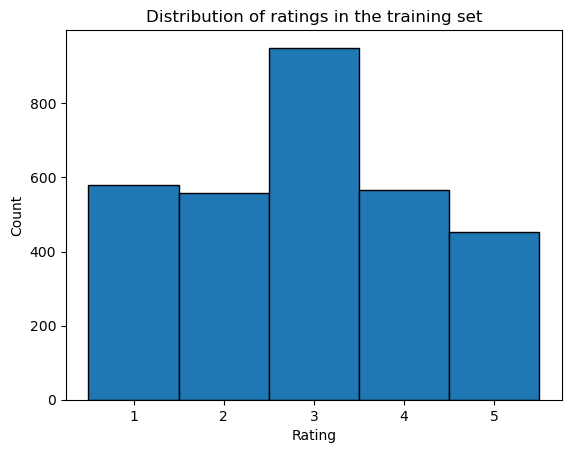

In [6]:
plt.figure()
plt.hist(
    ratings_train["rating"],
    bins=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5],
    edgecolor="black"
)
plt.xlabel("Rating")
plt.ylabel("Count")
plt.title("Distribution of ratings in the training set")
plt.xticks([1, 2, 3, 4, 5])
plt.show()



## 4. Visualize a small part of the item - user matrix

We are only showing a small block to see the pattern.


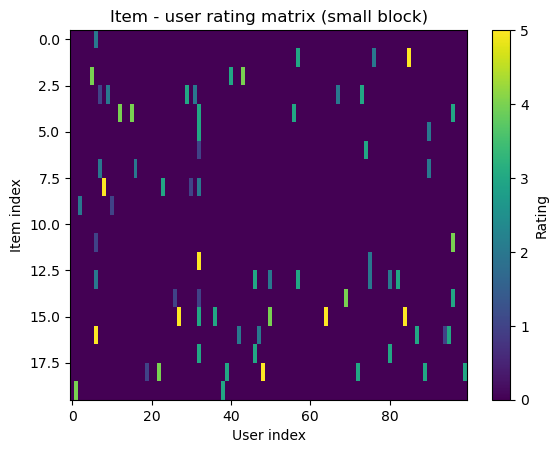

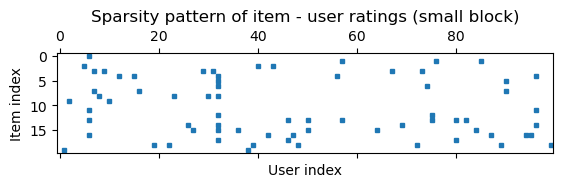

In [7]:
# Visualizing first 20 items and first 100 users
R_block = R[:20, :100]

plt.figure()
plt.imshow(R_block, aspect="auto", interpolation="nearest")
plt.colorbar(label="Rating")
plt.xlabel("User index")
plt.ylabel("Item index")
plt.title("Item - user rating matrix (small block)")
plt.show()

# Sparsity pattern of the same block
plt.figure()
plt.spy(R_block, markersize=3)
plt.xlabel("User index")
plt.ylabel("Item index")
plt.title("Sparsity pattern of item - user ratings (small block)")
plt.show()




## 5. Compute item - item cosine similarity

For two item vectors `r_i` and `r_j`:


$$\hat{r}_{u,i} = \frac{\sum_{j \in N(i;u)} \text{sim}(i,j) \cdot r_{u,j}}{\sum_{j \in N(i;u)} |\text{sim}(i,j)|}$$

- This formula written from Chatgpt for this markdown

The row of `R` as a vector of user ratings for that movie.


In [8]:
def cosine_similarity_matrix_item(R):
    """
    Compute item - item cosine similarity matrix.

    R: item - user rating matrix of shape (num_items, num_users)

    Returns:
        S: similarity matrix of shape (num_items, num_items)
    """
    # Norm of each item vector
    norms = np.linalg.norm(R, axis=1)  # shape: (num_items,)
    norms[norms == 0] = 1e-8  # avoid division by zero

    # Dot products between all pairs of items
    dot_products = R @ R.T  # shape: (num_items, num_items)

    # Outer product of norms for denominator
    norm_matrix = np.outer(norms, norms)

    S = dot_products / norm_matrix
    return S

S = cosine_similarity_matrix_item(R)
S.shape


(35, 35)

## 6. Visualize similarity profile of one item

Pick a movie from the training set and show how similar it is to all other movies.


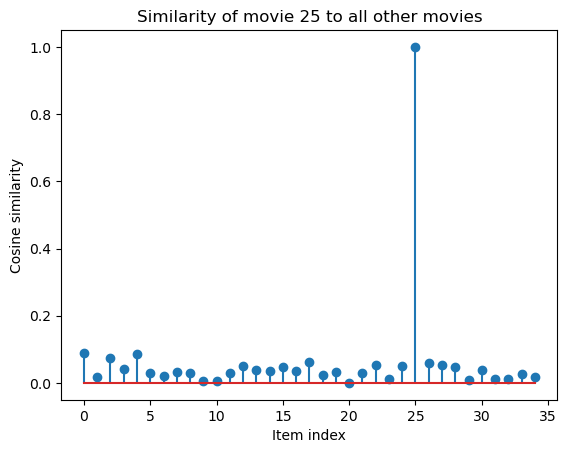

In [9]:
# Choosing a movie id from the training data
example_movie_id = ratings_train["movie_id"].iloc[0]
example_idx = movie_id_to_index[example_movie_id]

sims = S[example_idx]

plt.figure()
plt.stem(range(len(sims)), sims, use_line_collection=True)
plt.xlabel("Item index")
plt.ylabel("Cosine similarity")
plt.title(f"Similarity of movie {example_movie_id} to all other movies")
plt.show()


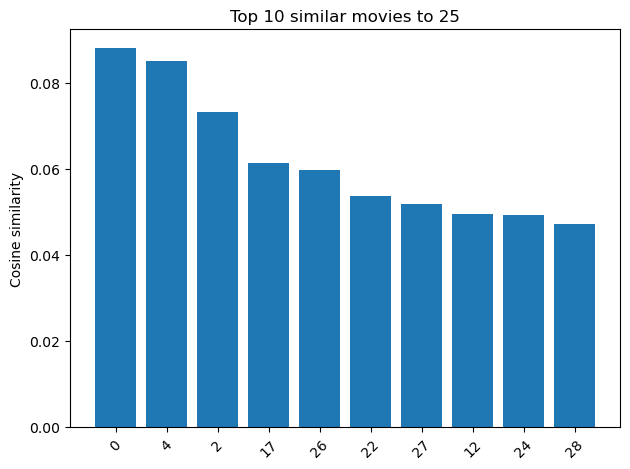

In [10]:
# Visualizing top-k similar movies
sims_copy = sims.copy()
sims_copy[example_idx] = -1e9  

top_k_example = 10
top_idx = np.argsort(sims_copy)[-top_k_example:][::-1]
top_vals = sims_copy[top_idx]
top_movie_ids = [list(movie_id_to_index.keys())[list(movie_id_to_index.values()).index(i)] for i in top_idx]

plt.figure()
plt.bar(range(top_k_example), top_vals)
plt.xticks(range(top_k_example), top_movie_ids, rotation=45)
plt.ylabel("Cosine similarity")
plt.title(f"Top {top_k_example} similar movies to {example_movie_id}")
plt.tight_layout()
plt.show()


## 7. Predictions ratings with item based CF

We now define a function that predicts a single rating for (user, movie) using item based collaborative filtering.

If we cannot compute a meaningful prediction, we fall back to a default rating.


In [11]:
# Global mean rating for fallback
global_mean_rating = ratings_train["rating"].mean()
global_mean_rating


2.921442369607212

In [12]:
def predict_single_rating(user_id, movie_id, R, S,
                          movie_id_to_index, user_id_to_index,
                          k=10, default_rating=None):
    """
    Predict rating for a single (user_id, movie_id) pair
    using item based collaborative filtering with cosine similarity.

    R: item - user matrix
    S: item - item similarity matrix
    k: neighborhood size
    default_rating: value to return if we cannot make a prediction
    """


    if default_rating is None:
        default_rating = global_mean_rating

    # If user or item is unknown, return default
    if movie_id not in movie_id_to_index or user_id not in user_id_to_index:
        return default_rating

    i = movie_id_to_index[movie_id]
    u = user_id_to_index[user_id]


    user_ratings = R[:, u]  # shape: (num_items,)

    sims = S[i].copy()
    sims[i] = 0.0  # remove self

    rated_items = np.where(user_ratings > 0)[0]
    if rated_items.size == 0:
        return default_rating

    sims_rated = sims[rated_items]
    ratings_rated = user_ratings[rated_items]

    if np.all(sims_rated == 0):
        return default_rating

    neighbor_idx = np.argsort(sims_rated)[-k:]
    neighbor_idx = neighbor_idx[::-1]

    sims_top = sims_rated[neighbor_idx]
    ratings_top = ratings_rated[neighbor_idx]

    numerator = np.sum(sims_top * ratings_top)
    denominator = np.sum(np.abs(sims_top))

    if denominator == 0:
        return default_rating

    return numerator / denominator


In [13]:
# Quick sanity check on one test example
sample_row = ratings_test.iloc[0]
sample_pred = predict_single_rating(
    user_id=sample_row["user_id"],
    movie_id=sample_row["movie_id"],
    R=R,
    S=S,
    movie_id_to_index=movie_id_to_index,
    user_id_to_index=user_id_to_index,
    k=10
)
sample_row, sample_pred


(movie_id     25.0
 user_id     630.0
 rating        4.0
 Name: 0, dtype: float64,
 3.5606122)

## 8. Evaluating MSE on the test set

We loop through the test data, predict ratings, and compute mean squared error.


In [14]:
def evaluate_mse(ratings_test, R, S,
                 movie_id_to_index, user_id_to_index,
                 k=10, default_rating=None):
    """
    Compute MSE on the test set for a given neighborhood size k.
    """
    if default_rating is None:
        default_rating = global_mean_rating

    y_true = []
    y_pred = []

    for _, row in ratings_test.iterrows():
        user_id = row["user_id"]
        movie_id = row["movie_id"]
        true_rating = row["rating"]

        pred_rating = predict_single_rating(
            user_id=user_id,
            movie_id=movie_id,
            R=R,
            S=S,
            movie_id_to_index=movie_id_to_index,
            user_id_to_index=user_id_to_index,
            k=k,
            default_rating=default_rating
        )

        y_true.append(true_rating)
        y_pred.append(pred_rating)

    mse = mean_squared_error(y_true, y_pred)
    return mse


In [15]:
# Trying a few k values
for k in [5, 10, 20]:
    mse_k = evaluate_mse(
        ratings_test=ratings_test,
        R=R,
        S=S,
        movie_id_to_index=movie_id_to_index,
        user_id_to_index=user_id_to_index,
        k=k
    )
    print(f"k = {k}, MSE = {mse_k:.4f}")


k = 5, MSE = 1.5434
k = 10, MSE = 1.5391
k = 20, MSE = 1.5399


In [16]:
neighborhood_sizes = [5, 10, 20]

for k in neighborhood_sizes:
    mse_k = evaluate_mse(
        ratings_test=ratings_test,
        R=R,
        S=S,
        movie_id_to_index=movie_id_to_index,
        user_id_to_index=user_id_to_index,
        k=k
    )
    print(f"Neighborhood size k = {k}, MSE = {mse_k:.4f}")


Neighborhood size k = 5, MSE = 1.5434
Neighborhood size k = 10, MSE = 1.5391
Neighborhood size k = 20, MSE = 1.5399


## 9. Visualize MSE vs neighborhood size

Now we run the evaluation for several values of k and plot the MSE curve.


k =  2, MSE = 1.5808
k =  5, MSE = 1.5434
k = 10, MSE = 1.5391
k = 15, MSE = 1.5394
k = 20, MSE = 1.5399
k = 30, MSE = 1.5398
k = 40, MSE = 1.5398
k = 50, MSE = 1.5398


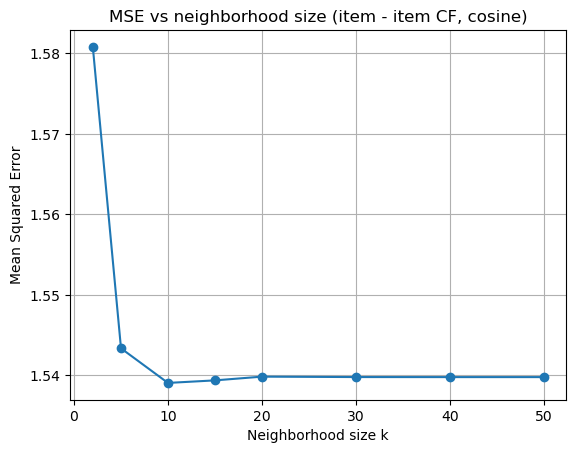

In [17]:
neighborhood_sizes = [2, 5, 10, 15, 20, 30, 40, 50]
mse_values = []

for k in neighborhood_sizes:
    mse_k = evaluate_mse(
        ratings_test=ratings_test,
        R=R,
        S=S,
        movie_id_to_index=movie_id_to_index,
        user_id_to_index=user_id_to_index,
        k=k
    )
    mse_values.append(mse_k)
    print(f"k = {k:2d}, MSE = {mse_k:.4f}")

plt.figure()
plt.plot(neighborhood_sizes, mse_values, marker="o")
plt.xlabel("Neighborhood size k")
plt.ylabel("Mean Squared Error")
plt.title("MSE vs neighborhood size (item - item CF, cosine)")
plt.grid(True)
plt.show()


## 10. Short interpretation


- An **MSE around 1.5** means the model is doing much better.  
  The RMSE is `sqrt(1.5) ≈ 1.22`, so predictions are usually within about 1 rating point of the true rating.  
  That is reasonable for a simple item - item collaborative filtering model.

The Report will be added to the  folder. 